Alexandre CHEVAUX & Virgile AMATO

### Introduction

Import des librairies 

In [146]:
# pour la fonction persp3d
require("rgl")
# pour la fonction quad2d
require("pracma")

#install.packages("rgl")

On se propose, dans ce projet, d'étuder l'intégrale de la fonction h suivante : 
On essaye ici de calculer:
$$\text{I = } \int_{0}^{2}\int_{0}^{3} f(x,y) dx dy $$
$$ \text{ avec} f(x,y) = 1+log(x+y)*(2*x)$$

In [134]:
h = function
    (x, y)
{
  return(1 + log(x + y) * 2 * x)
}

on affiche la fonction en 3D afin de l'étudier, notamment son domaine de définition (support), ainsi que son domaine d'arrivée :
Persp3d ne fonctionnant pas correctement dans Jupyter Notebook, le graphe est disponible dans l'annexe graphe et le code dans projet1_script.r

On définit certains paramètres, notamment le maximum de la fonction, en analysant le graph 3d de celle-ci.

In [147]:
# nombres totales de simulations
n = 1000
# bornes de l'espace de définition de X
inf_x = 0
sup_x = 2
# bornes de l'espace de définition de Y
inf_y = 0
sup_y = 3
# En regardant la fonction dans persp3d, on peut voir que h est à valeur dans [0, 8]
inf_v = 0
sup_v = 8

Nous souhaitons approximer l'intégrale de cette fonction (fonction de 2 variables donc double intégrale), qu'on nonte H.
Nous utiliserons pour celà 4 méthodes, que nous comparerons, notamment en terme de vitesse d'éxecution, de vitesse de convergence, et de biais.
Les 4 méthodes utilisées sont : 
- Méthode du Rejet
- Méthode de Monte-Carlo
- Méthode de la Fonction de Répartition inverse
- Méthode de la Copule

On calcul dans un premier temps la "vrai valeur" de la double intégrale de h (noté, pour rappel H),
à l'aide d'une fonction R : quad2d
- quad --> permet de calculer une intégrale simple
- quad2d --> permet de calculer une intégrale double
- quad3d --> permet de calculer une intégrale triple

In [117]:
H = quad2d(h, inf_x, sup_x, inf_y, sup_y)
paste("Vraie valeur de l'intégrale de h : ", H)

[1] "Vraie valeur de l'intégrale de h :  17.6027082428666"

### 1) méthode du Rejet


Pour cela nous utilisons dans un 1er temps la méthode du rejet:
On simule 3 variables aléatoires. 
Et on regarde le nombre de fois où le point simulé est supérieur ou inférieur à f.
Or d'après la loi des grands nombres:
$$ Sn= \frac{1}{n} \sum_{i=1}^{n}\mathbb{1}[V_i \leqslant f(Ux_i,Uy_i)] \underset{p.s}{\longrightarrow} \mathbb{P} (V_i \leqslant f(Ux_i,Uy_i)  = \frac{\int_{0}^{2}\int_{0}^{3} f(x,y) dx dy}{K} $$
$$ \text{avec } U_x = \mathbb{U}[0,2] U_y = \mathbb{U}[0,3] \text{ et } V = \mathbb{U}[0,8]  $$
$$ \text{Ainsi } 2*3*8*Sn= \int_{0}^{2}\int_{0}^{3} f(x,y) dx dy $$

In [148]:
ux = runif(n, inf_x, sup_x)
uy = runif(n, inf_y, sup_y)

v = runif(n, inf_v, sup_v)

# Méthode A
# Marche bien mais on veut pouvoir afficher la convergence
#Sn = 1/n * sum(v <= h(ux, uy))
#I = Sn * ((sup_x-inf_x)*(sup_y-inf_y)*(sup_v-inf_v))
#paste("valeur de l'intégrale estimé par la méthode 1 : ", I)

# Méthode B
keeped_values = v <= h(ux, uy) * 1
Sn_array1 = 1/(1:n) * cumsum(keeped_values) * ((sup_x-inf_x)*(sup_y-inf_y)*(sup_v-inf_v))
Sn1 = 1/n * sum(keeped_values) * ((sup_x-inf_x)*(sup_y-inf_y)*(sup_v-inf_v))
biais1 = mean(Sn_array1[n]) - H
variance1 = var(Sn_array1 - H)

### 2) méthode de Monte-Carlo

La méthode du rejet nécessite de simuler 3 uniformes or il est possible d'améliorer ceci. 
En effet on remarque que: 
$$ I= \int_{-\infty}^{+\infty}\int_{-\infty}^{+\infty} f(x,y) \mathbb{1}[ V[0,2] \mathbb{1}[ U[0,3] dx dy = \mathbb{E}[f(V)] $$
On simule N fois U et V 
$$ Sn= \frac{1}{n} \sum_{i=1}^{n} f(U_i,V_i) \underset{n\to +\infty}{\longrightarrow} I $$


In [149]:

x = runif(n, inf_x, sup_x)
y = runif(n, inf_y, sup_y)

Sn_array2 = (sup_x-inf_x) * (sup_y-inf_y) * cumsum(h(x, y))/(1:n)
Sn2 =  1/n * (sup_x-inf_x) * (sup_y-inf_y) * sum(h(x, y))
biais2 = mean(Sn_array2[n]) - H
variance2 = var(Sn_array2 - H)

### 2.1) méthode de Monte-Carlo - Variables Antithétiques

Cette méthode reprend l'idée d'un Monte Carlo classique.
Mais on l'applique non pas en simulant n uniforme mais on remarque que:
$$ \mathbb{U}_1 \text{ et } 1-\mathbb{U}_1 \text{ont même loi} $$
$$ \text{on a donc } I=\frac{1}{2} \mathbb{E}[f(U_1)+f(1-U_1)] $$
$$ \text{et donc} \tilde{S}_{2n} =\frac{1}{2n}\sum_{i=1}^{n} f(U_i)+ f(1-U_i)$$
    
L'avantage principale est d'améliorer la vitesse de convergence :
Nous avons deux nouvelles observations (u et 1-u) à chaque nouvelle simulation de u.


In [150]:
# On approxime l'intégral de f(x) par l'esperance de f(u) avec u une uniforme
# sur le support de x (si x défini sur [0, 3] alors u uniforme sur [0, 3])
# On applique la méthode des variables antithétiques : à chaque uniforme u, 
# on calcule l'esperance de 1/2 * (f(u) + f(sup(X) - u))
# pour l'exemple précedent, celà donne : 1/2 * (f(u) + f(3 - u))
# -> l'avantage principale est d'améliorer la vitesse de convergence :
# -> on a deux nouvelles observations (u et 1-u) à chaque nouvelle simulation de u 
# -> c'est la méthode des variables antithétiques
x = runif(n, inf_x, sup_x)
y = runif(n, inf_y, sup_y)

Sn_array21 = (sup_x-inf_x) * (sup_y-inf_y) * cumsum(h(x, y) + h(sup_x - x, sup_y - y))/(2*(1:n))
Sn21 =  1/n * (sup_x-inf_x) * (sup_y-inf_y) * sum(1/2 * (h(x, y) + h(sup_x - x, sup_y - y)))
biais21 = mean(Sn_array21[n]) - H
variance21 = var(Sn_array21 - H)

### 3) méthode de la FdR inverse

Approximation des densités marginales par des fonctions affines

Ceci est une généralisation des méthodes de Monte Carlo:
On pose:
$$ I= \int_{\mathbb{R}^d}  \frac{f(x)}{p(x)}*p(x)dx $$
$$ \text{où p est une densité} $$
 On a d'après le théorème de convergence monotone:
$$ S_n=\frac{1}{n}\sum_{i=1}^{n}  \frac{f(X_i)}{p(X_i)}\underset{n\to +\infty}{\longrightarrow} I $$
Il est essentiel de trouver une fonction p qui "ressemble" à notre fonction.
On choisit ici deux fonctions affines:
$$ f(x) =0.2+0.3*x $$
$$ f(x)=\frac{2}{15}+ \frac{2}{15}*x $$

In [138]:
fx = function(x)
{
  return((0.2+0.3*x)*(x>=0 && x<=2))
}

fy = function(y)
{
  return((2/15+ 2/15*y)*(x>=0 && x<=3))
}

# on vérifie que les intégrales sur leurs supports respectifs
# valent 1
quad(fx, 0, 2)
quad(fy, 0, 3)

[1] 1

[1] 1

Simulations de nos X et Y, à partir de la méthode d'inversion

Calcul des fonctions de répartition de X et Y à partir de leurs densités

In [139]:
Fx = function(x)
{
  return((0.2*x+(0.15*x^2)))
}

Fy = function(y)
{
  return(2/15*x+ (1/30*x^2))
}

Calcul des fonction de répartition inverse

In [140]:
Fx_inv = function(x)
{
  return(sqrt(20/3 * x + 4/9) - 2/3)
}

Fy_inv = function(y)
{
  return(sqrt(15*y + 1) - 1)
}

Maintenant que nous avons les fonctions de répartion inverse on peut simuler nos X et Y !

In [151]:
#u = runif(n, inf_v, sup_v)
u = runif(n, 0, 1)
X = Fx_inv(u)
Y = Fy_inv(u)
Sn_array3 = 1/(1:n) * cumsum(h(X, Y)/(fx(X)*fy(Y)))
Sn3 = 1/n * sum(h(X, Y)/(fx(X)*fy(Y)))
biais3 = mean(Sn_array3[n]) - H
variance3 = var(Sn_array3 - H)

### 4) Méthode de la Copule

Dans cette méthode, nous appliquerons les résultats d'une méthode de Monte Carlo mais avec une densité issue du théorème de Sklar. En effet d'après ce dernier:
$$ p(x)= f(x)*f(y)*c(F(x),F(Y)) \text{ est une densité}$$
$$\text{avec c une copule} $$

Dans notre exemple nous utiliserons, la copule de Franck.
Pour rappel la copule de Franck est 

$$ C(u,v)=\frac{-1}{\theta} ln(1 +\frac{(e^{-\theta u}-1)(e^{-\theta v}-1)}{(e^{-\theta}-1} $$


En dérivant deux fois selon u et v on obtient c(u,v)
$$ c(u,v)= \frac{-\theta *(e^{-\theta u}*(e^{-\theta v}(e^{-\theta}-1)}{((e^{-\theta}-1)+((e^{-\theta u}-1)(e^{-\theta v}-1))^{2}} $$

Mais pour avoir le maximum de points au voisinage du point de coordonnées (1,1), nous renversons la fonction selon v.


In [142]:
franck=function(u,v) {
  teta=0.55
  v=1-v
    return( (-teta*exp(-teta*u)*exp(-teta*v)*(exp(-teta)-1))/(((exp(-teta)-1)+(exp(-teta*u)-1)*(exp(-teta*v)-1))^2))}

In [152]:
h_copule=function(x,y) { fx(x)*fy(y)*franck(Fx(x),Fy(y))}

On peut vérifier que h_copule a un graphe similaire à celui de notre fonction:
Ces graphes peuvent être trouvé en annexe.

In [153]:
u = runif(n, 0, 1)
v=  runif(n, 0, 1)
X = Fx_inv(u)
Y = Fy_inv(v)

Sn_array4 = 1/(1:n) * cumsum(h(X,Y)/(h_copule(X,Y)))
Sn4 = 1/n * sum(h(X,Y)/h_copule(X,Y))
biais4 = mean(Sn_array3[n]) - H
variance4 = var(Sn_array3 - H)



### Affichage des résultats

[1] Vraie valeur de l'intégrale de h :  17.6027082428666
[1] Méthode 1:
[1] Valeur de l'intégrale de h :  16.896 biais:  -0.706708242866586  variance 1.42215193240954
[1] Méthode 2:
[1] valeur de l'intégrale de h estimé par la méthode 2 :  17.9922257477573 biais:  0.389517504890719  variance 0.549436007845468
[1] Méthode 2.1:
[1] valeur de l'intégrale de h estimé par la méthode 2.1 :  17.627732324481 biais:  0.0250240816144185  variance 0.00826357223387912
[1] Méthode 3:
[1] valeur de l'intégrale de h estimé par la méthode 3 :  17.1957040834604 biais:  -0.407004159406153  variance 0.0110099741574984
[1] Méthode 4:
[1] valeur de l'intégrale de h estimé par la méthode 4 :  17.5503530066642 biais:  -0.407004159406153  variance 0.0110099741574984


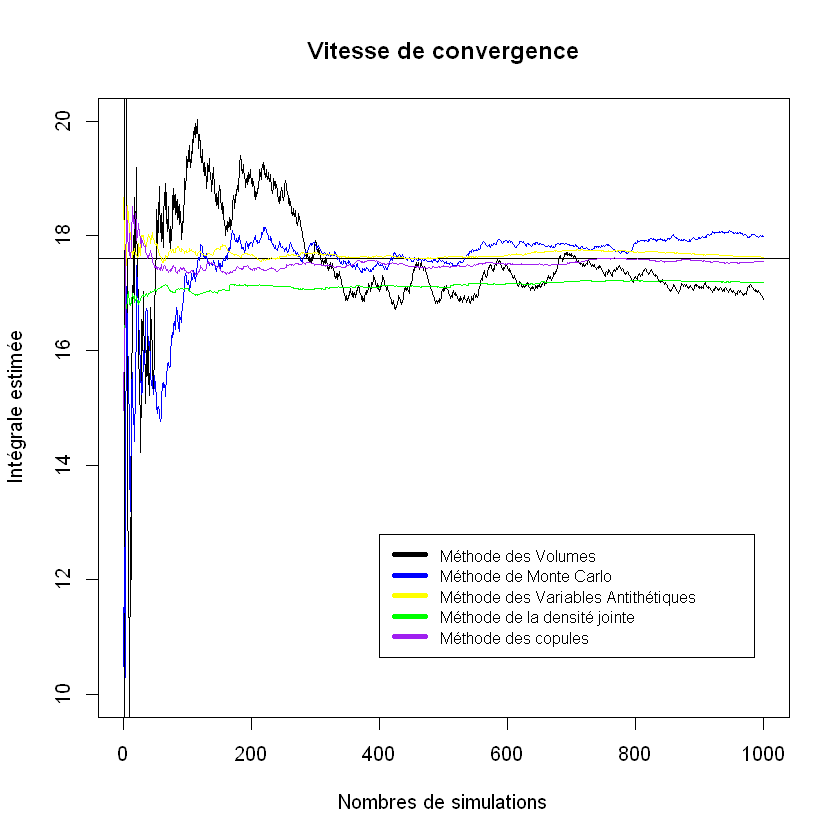

In [154]:
# "Vrai valeur de l'intégrale de h
print(paste("Vraie valeur de l'intégrale de h : ", H),quote=FALSE)
# On affiche les résultat des approximations
print(paste("Méthode 1:"),quote=FALSE)
print(paste("Valeur de l'intégrale de h : ", Sn1,"biais: ",biais1, " variance", variance1 ),quote=FALSE) 
print(paste("Méthode 2:"),quote=FALSE)
print(paste("valeur de l'intégrale de h estimé par la méthode 2 : ", Sn2,"biais: ",biais2, " variance", variance2),quote=FALSE )
print(paste("Méthode 2.1:"),quote=FALSE)
print(paste("valeur de l'intégrale de h estimé par la méthode 2.1 : ", Sn21,"biais: ", biais21, " variance", variance21),quote=FALSE )
print(paste("Méthode 3:"),quote=FALSE)
print(paste("valeur de l'intégrale de h estimé par la méthode 3 : ", Sn3,"biais: ", biais3, " variance", variance3),quote=FALSE )
print(paste("Méthode 4:"),quote=FALSE)
print(paste("valeur de l'intégrale de h estimé par la méthode 4 : ", Sn4,"biais: ", biais4, " variance", variance4),quote=FALSE )


# On affiche le graph des 5 estimateurs afin d'étudier
# la vitesse de convergence vers la "vrai valeur"
plot(Sn_array1,
     col="gray0",
     type="l",
     ylim=c(10,20),
     #xlim=x(100, n),
     main="Vitesse de convergence",
     xlab="Nombres de simulations",
     ylab="Intégrale estimée")
abline(H, 0)
lines(Sn_array2,type="l", col="blue")
lines(Sn_array21, col="yellow")
lines(Sn_array3, col="green")
lines(Sn_array4, col="purple")




legend(400, 12.8,
       legend=c("Méthode des Volumes",
                "Méthode de Monte Carlo",
                "Méthode des Variables Antithétiques",
                "Méthode de la densité jointe",
                "Méthode des copules"),
       col=c("gray0",
             "blue",
             "yellow",
             "green",
             "purple"),
       lwd=4,
       cex=0.8)

$$\textbf{Conclusion:} $$
On remarque que l'on obtient des résulats cohérants avec ceux attendus. 
Les méthodes des copules et des variables antithétiques sont celles qui convergent le plus vite et dont l'écart avec la donnée réelle est la meilleure. La convergence des modèles est relativement similaire mais  la méthode des variables anithétiques posséde un biais et une variance plus faible.